In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, CatBoost

# Загрузим train и test

In [2]:
# путь общий
path = "C:\\Users\\dgalk\\kaggle\\Titanic\\"

In [3]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
# посмотрим на train
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print("Всего объектов на обучении: {0}".format(train.shape[0]))

Всего объектов на обучении: 891


# Выделим признаки и целевую переменную для обучения

In [5]:
X_col = [col for col in train.columns if col not in ['PassengerId', 'Survived']]

X = train[X_col]
y = train.Survived

# Анализ признаков на трейне

Посмотрим, в каких колонках есть пропуски и сколько их

In [6]:
for col in X.columns:
    if col not in ['Sex', 'Age']:
        print("Кол-во пропусков в {0}:\t{1}".format(col, X[pd.isnull(X[col])].shape[0]))
    else:
        print("Кол-во пропусков в {0}:\t\t{1}".format(col, X[pd.isnull(X[col])].shape[0]))

Кол-во пропусков в Pclass:	0
Кол-во пропусков в Name:	0
Кол-во пропусков в Sex:		0
Кол-во пропусков в Age:		177
Кол-во пропусков в SibSp:	0
Кол-во пропусков в Parch:	0
Кол-во пропусков в Ticket:	0
Кол-во пропусков в Fare:	0
Кол-во пропусков в Cabin:	687
Кол-во пропусков в Embarked:	2


> *Больше всего пропусков у признака Cabin - почти 80%. У Age ~20% пропусков*

+ **Cabin**

In [7]:
print("\n-> Кол-во объектов, у которых признак Cabin не Nan: {0}\n".format(train[~pd.isnull(train.Cabin)]['Cabin'].size))
print("\n-> Из них уникальных: {0}\n".format(train[~pd.isnull(train.Cabin)]['Cabin'].unique().size))


-> Кол-во объектов, у которых признак Cabin не Nan: 204


-> Из них уникальных: 147



> *Может и можно из этого признака что выжать: например, из одной кабины все спаслись или наоброт...*

In [8]:
cabins = X.Cabin.str.split()

cabin_first_letter = np.array([cabin[0][0] for cabin in cabins if type(cabin) is not float and len(cabin) > 0])

np.unique(cabin_first_letter, return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], dtype='<U1'),
 array([15, 47, 59, 33, 32, 13,  4,  1], dtype=int64))

+ **Ticket**

In [9]:
print("\n-> Кол-во объектов с уникальным Ticket: {0}\n".format(train.Ticket.unique().size))


-> Кол-во объектов с уникальным Ticket: 681



> *Получается есть люди с одинаковым номером билета*

In [10]:
tickets = train.Ticket.str.split()
print(np.unique(np.array([ticket[0][0] if len(ticket) > 1 else "" for ticket in tickets]), return_counts=True))

(array(['', 'A', 'C', 'F', 'P', 'S', 'W'], dtype='<U1'), array([665,  29,  47,   7,  65,  65,  13], dtype=int64))


> Это первые буквы в билетах

+ **Embarked**

In [11]:
ports = X['Embarked'].unique()[:3]
for port in ports:
    print("Кол-во человек, которые сели в {0}: {1}".format(port, X[X.Embarked == port].shape[0]))

Кол-во человек, которые сели в S: 644
Кол-во человек, которые сели в C: 168
Кол-во человек, которые сели в Q: 77


> *Больше всего человек село в **S**. Заменим пропуски на S*

+ **Name**

In [12]:
train.Name.str.split().head()

0                         [Braund,, Mr., Owen, Harris]
1    [Cumings,, Mrs., John, Bradley, (Florence, Bri...
2                           [Heikkinen,, Miss., Laina]
3    [Futrelle,, Mrs., Jacques, Heath, (Lily, May, ...
4                        [Allen,, Mr., William, Henry]
Name: Name, dtype: object

> *Пока непонятно для меня, что значит первое имя в данном признаке. Но предположим, что это что-то, что указывает на семейное родство. Если одинаковое, то из одной семьи.*

+ **Fare**

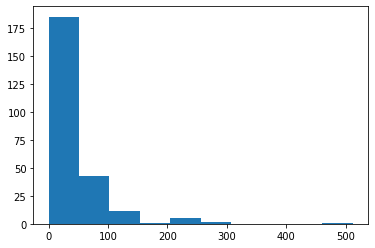

In [13]:
fares = plt.hist(X.Fare.unique())

In [14]:
X[X.Fare > 300]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


> Странный хвост... Можно его потом медианой по первому классу заменить

+ **Age**

In [15]:
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
for pclass in [1, 2, 3]:
    print("Средний возраст в {0}-м классе: {1}".format(
        pclass,
        X[X.Pclass == pclass]['Age'].median()
    ))

Средний возраст в 1-м классе: 37.0
Средний возраст в 2-м классе: 29.0
Средний возраст в 3-м классе: 24.0


> Более взрослый - более богатый. Логично:)

# Sex: one-hot-encoding

In [17]:
X = pd.concat([X.drop('Sex', axis=1), pd.get_dummies(X.Sex)], axis=1)
X.head()

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,female,male
0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0
4,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1


# Embarked: one-hot-encoding

In [18]:
# заменим 2 Nan на S
X['Embarked'] = X['Embarked'].fillna("S")

X = pd.concat([X.drop('Embarked', axis=1), pd.get_dummies(X.Embarked)], axis=1)
X.head()

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,female,male,C,Q,S
0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1
4,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1


# Fare

In [19]:
X.loc[X.Fare > 300, 'Fare'] = X[X.Pclass == 1]['Fare'].median()

# Ticket $\rightarrow$ first letter $\rightarrow$ one-hot-encoding

In [20]:
tickets = train.Ticket.str.split()

X['ticket_first_letter'] = np.array([ticket[0][0] if len(ticket) > 1 else "" for ticket in tickets])
ticket_first_letter = pd.get_dummies(X['ticket_first_letter'])
ticket_first_letter.columns = [
    'ticket_',
    'ticket_A', 'ticket_C', 'ticket_F',
    'ticket_P', 'ticket_S', 'ticket_W'
]

X = pd.concat([X.drop(['Ticket', 'ticket_first_letter'], axis=1), ticket_first_letter], axis=1)
X.head()

,Pclass,Name,Age,SibSp,Parch,Fare,Cabin,female,male,C,Q,S,ticket_,ticket_A,ticket_C,ticket_F,ticket_P,ticket_S,ticket_W
0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,NaN,0,1,0,0,1,0,1,0,0,0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,C85,1,0,1,0,0,0,0,0,0,1,0,0
2,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,NaN,1,0,0,0,1,0,0,0,0,0,1,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,C123,1,0,0,0,1,1,0,0,0,0,0,0
4,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,NaN,0,1,0,0,1,1,0,0,0,0,0,0


# Age: заполнение пропусков медианой с сечением по Pclass

In [21]:
X['age_median'] = X['Age']

for pclass in [1, 2, 3]:
    X.loc[(X.Pclass == pclass) & pd.isnull(X.Age), 'age_median'] = \
        X[X.Pclass == pclass]['age_median'].median()

X.head(6)

,Pclass,Name,Age,SibSp,Parch,Fare,Cabin,female,male,C,Q,S,ticket_,ticket_A,ticket_C,ticket_F,ticket_P,ticket_S,ticket_W,age_median
0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,NaN,0,1,0,0,1,0,1,0,0,0,0,0,22.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,C85,1,0,1,0,0,0,0,0,0,1,0,0,38.0
2,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,NaN,1,0,0,0,1,0,0,0,0,0,1,0,26.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,C123,1,0,0,0,1,1,0,0,0,0,0,0,35.0
4,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,NaN,0,1,0,0,1,1,0,0,0,0,0,0,35.0
5,3,"Moran, Mr. James",NaN,0,0,8.4583,NaN,0,1,0,1,0,1,0,0,0,0,0,0,24.0


# Name

In [22]:
names = train.Name.str.split(',')
X['surname'] = 0

for i, name in enumerate(names):
    X.loc[i, 'surname'] = name[0]
    
X.head()

,Pclass,Name,Age,SibSp,Parch,Fare,Cabin,female,male,C,...,S,ticket_,ticket_A,ticket_C,ticket_F,ticket_P,ticket_S,ticket_W,age_median,surname
0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,NaN,0,1,0,...,1,0,1,0,0,0,0,0,22.0,Braund
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,C85,1,0,1,...,0,0,0,0,0,1,0,0,38.0,Cumings
2,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,NaN,1,0,0,...,1,0,0,0,0,0,1,0,26.0,Heikkinen
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,C123,1,0,0,...,1,1,0,0,0,0,0,0,35.0,Futrelle
4,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,NaN,0,1,0,...,1,1,0,0,0,0,0,0,35.0,Allen


In [23]:
print("\n-> Кол-во уникальных surname: {0}\n".format(X.surname.unique().size))


-> Кол-во уникальных surname: 667



# Заменим все Nan на пустые строки в признаке Cabin

In [24]:
X['Cabin'] = X['Cabin'].fillna("")

In [25]:
cabins = X.Cabin.str.split()

cabin_first_letter = np.array([cabin[0][0] if len(cabin) != 0 else "" for cabin in cabins])

X['cabin_first_letter'] = cabin_first_letter

**Проделаем тот же путь для тестовых данных**

In [26]:
# Sex
test = pd.concat([test.drop('Sex', axis=1), pd.get_dummies(test.Sex)], axis=1)
# Embarked
test = pd.concat([test.drop('Embarked', axis=1), pd.get_dummies(test.Embarked)], axis=1)
# Age
test['age_median'] = test['Age'].fillna(test.Age.median())
test['age_mean'] = test['Age'].fillna(test.Age.mean())
# Name
names = test.Name.str.split(',')
test['surname'] = 0
for i, name in enumerate(names):
    test.loc[i, 'surname'] = name[0]

# Fare
test.loc[test.Fare > 300, 'Fare'] = test[test.Pclass == 1]['Fare'].median()
# есть один Nan в признаке Fare: заменим на медиану
test['Fare'] = test['Fare'].fillna(test[test.Pclass == 3]['Fare'].median())

# Ticket
tickets = test.Ticket.str.split()
test['ticket_first_letter'] = np.array([ticket[0][0] if len(ticket) > 1 else "" for ticket in tickets])
ticket_first_letter = pd.get_dummies(test['ticket_first_letter'])
ticket_first_letter.columns = [
    'ticket_',
    'ticket_A', 'ticket_C', 'ticket_F',
    'ticket_L',
    'ticket_P', 'ticket_S', 'ticket_W'
]
test = pd.concat([test.drop(['Ticket', 'ticket_first_letter'], axis=1), 
                  ticket_first_letter.drop('ticket_L', axis=1)], 
                 axis=1)

# заменим все Nan в Cabin на пустую строку
test['Cabin'] = test['Cabin'].fillna("")
cabins = test.Cabin.str.split()
cabin_first_letter = np.array([cabin[0][0] if len(cabin) != 0 else "" for cabin in cabins])
test['cabin_first_letter'] = cabin_first_letter

test.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,Cabin,female,male,...,age_mean,surname,ticket_,ticket_A,ticket_C,ticket_F,ticket_P,ticket_S,ticket_W,cabin_first_letter
0,892,3,"Kelly, Mr. James",34.5,0,0,7.8292,,0,1,...,34.5,Kelly,1,0,0,0,0,0,0,
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,7.0000,,1,0,...,47.0,Wilkes,1,0,0,0,0,0,0,
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,9.6875,,0,1,...,62.0,Myles,1,0,0,0,0,0,0,
3,895,3,"Wirz, Mr. Albert",27.0,0,0,8.6625,,0,1,...,27.0,Wirz,1,0,0,0,0,0,0,
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,12.2875,,1,0,...,22.0,Hirvonen,1,0,0,0,0,0,0,


# Признаки, на которых будем обучаться

+ **Числовые признаки**

In [27]:
col_num = ['Pclass', 'SibSp', 'Parch', 'Fare', 'age_median', 'female', 'male', 'C', 'Q', 'S', 
           'ticket_', 'ticket_A', 'ticket_C', 'ticket_F', 'ticket_P', 'ticket_S', 'ticket_W']

+ **Нечисловые признаки**

In [34]:
col_object = ['cabin_first_letter', 'surname']

+ **Все признаки**

In [35]:
col_all = col_num + col_object

# -----------------------------Обучение-----------------------------

# Разобьем на train и отложенный тест

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2,
                                                  random_state=123,
                                                  shuffle=True)

# Нормализуем все данные

In [37]:
scaler = StandardScaler()
# X_train
scaler.fit(X_train[col_num])
X_train_norm = pd.DataFrame(scaler.transform(X_train[col_num]))
X_train_norm.columns = X_train[col_num].columns
# X_val
scaler.fit(X_val[col_num])
X_val_norm = pd.DataFrame(scaler.transform(X_val[col_num]))
X_val_norm.columns = X_val[col_num].columns
# test
scaler.fit(test[col_num])
test_norm = pd.DataFrame(scaler.transform(test[col_num]))
test_norm.columns = test[col_num].columns

# Дополнительные функции

In [32]:
def plot_grid_search(grid_cv, key, figsize=(10,5), title='', xlabel=''):
    '''
    Отображение результатов работы GridSearch: график среднего значения + доверительный интервал
    '''
    # ось Х: варьируемый параметр
    x = [grid_cv.cv_results_['params'][i][key] for i in range(len(grid_cv.cv_results_['params']))]
    # среднее качество на тесте
    y_mean_test = grid_cv.cv_results_["mean_test_score"]
    # доверительный интервал на тесте
    y_low_test = y_mean_test - 2 * grid_cv.cv_results_["std_test_score"]
    y_high_test = y_mean_test + 2 * grid_cv.cv_results_["std_test_score"]
    # среднее качество на трейне
    y_mean_train = grid_cv.cv_results_["mean_train_score"]
    # доверительный интервал на трейне
    y_low_train = y_mean_train - 2 * grid_cv.cv_results_["std_train_score"]
    y_high_train = y_mean_train + 2 * grid_cv.cv_results_["std_train_score"]   
    # построение графики
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    # график - тест
    ax.plot(x, y_mean_test, color='tab:brown', label='test', linewidth=4)
    ax.fill_between(x, y_low_test, y_high_test, alpha=0.5)
    # график - трейн
    ax.plot(x, y_mean_train, color='tab:green', label='train', linewidth=4, linestyle='--')
    ax.fill_between(x, y_low_train, y_high_train, alpha=0.4)
    # оси и легенда
    ax.grid(linestyle='--')
    ax.legend(fontsize=14)

In [33]:
def to_kaggle(y_pred, file_name):
    '''
    Запись y_pred в filename.csv
    '''
    final = pd.DataFrame()
    final['PassengerId'] = test['PassengerId']
    final['Survived'] = y_pred
    final.to_csv(path + file_name + '.csv', 
                 index=False)

# Decision Tree

**GridSearch + график среднего кач-ва и доверительного интервала (ROC_AUC)**

best_param = {'max_depth': 3}
best_score = 0.8342536199432751


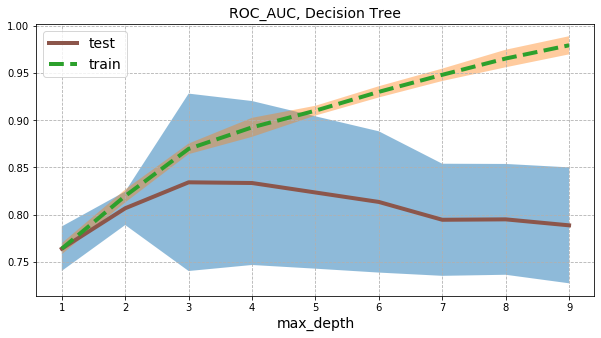

In [33]:
dtc = DecisionTreeClassifier()

# проведем GridSearch по глубине
parameters = {
    'max_depth': range(1, 10),
}
grid_cv_dtc = GridSearchCV(dtc, parameters, scoring='roc_auc', cv=5, return_train_score=True)
grid_cv_dtc.fit(X_train[col_num], y_train)

# полученные параметры и кач-во
print("best_param =", grid_cv_dtc.best_params_)
print("best_score =", grid_cv_dtc.best_score_)

# график
plot_grid_search(grid_cv_dtc, key='max_depth', title='ROC_AUC, Decision Tree', xlabel='max_depth')

**GridSearch + график среднего кач-ва и доверительного интервала (Accuracy)**

best_param = {'max_depth': 4}
best_score = 0.8075741160248203


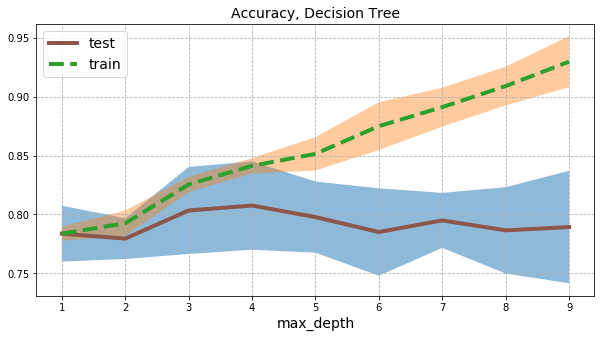

In [34]:
dtc = DecisionTreeClassifier()

# проведем GridSearch по глубине
parameters = {
    'max_depth': range(1, 10),
}
grid_cv_dtc = GridSearchCV(dtc, parameters, scoring='accuracy', cv=5, return_train_score=True)
grid_cv_dtc.fit(X_train[col_num], y_train)

# полученные параметры и кач-во
print("best_param =", grid_cv_dtc.best_params_)
print("best_score =", grid_cv_dtc.best_score_)

# график
plot_grid_search(grid_cv_dtc, key='max_depth', title='Accuracy, Decision Tree', xlabel='max_depth')

**GridSearch + график среднего кач-ва и доверительного интервала (F1 score)**

best_param = {'max_depth': 4}
best_score = 0.73274279959179


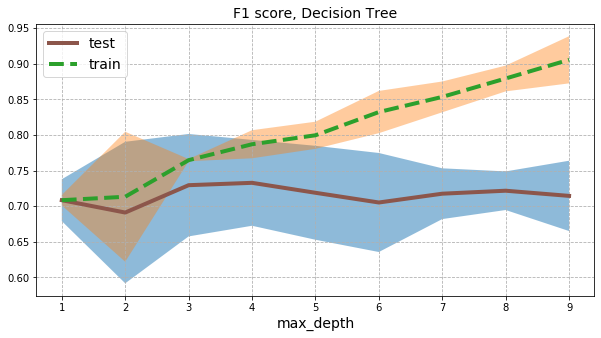

In [35]:
dtc = DecisionTreeClassifier()

# проведем GridSearch по глубине
parameters = {
    'max_depth': range(1, 10),
}
grid_cv_dtc = GridSearchCV(dtc, parameters, scoring='f1', cv=5, return_train_score=True)
grid_cv_dtc.fit(X_train[col_num], y_train)

# полученные параметры и кач-во
print("best_param =", grid_cv_dtc.best_params_)
print("best_score =", grid_cv_dtc.best_score_)

# график
plot_grid_search(grid_cv_dtc, key='max_depth', title='F1 score, Decision Tree', xlabel='max_depth')

+ Лучшее среднее качество достигается при максимальных глубинах 3 и 4 на всех метриках.

+ На метриках ROC_AUC и Accuracy доверительный интервал меньше всего при глубине 2, что хорошо. И переобучение меньше всего.

+ На метрике F1_score при глубине 2 наоборот большой доверительный интервал. А при глубинах 3 и 4 наоборот получше картина. Но лучше взять 3, т.к. переобучение чуть меньше.

+ Остановимся на **max_depth=2 и max_depth=3**. Тут хорошие доверительные интервалы и переобучение меньше

In [36]:
for max_depth_ in [2, 3]:
    dtc = DecisionTreeClassifier(max_depth=max_depth_)
    dtc.fit(X_train[col_num], y_train)
    y_pred = dtc.predict(X_val[col_num])
    y_pred_proba = dtc.predict_proba(X_val[col_num])[:, 1]
    print("\nmax_depth={0}".format(max_depth_))
    print("test\troc_auc:\t{0}".format(metrics.roc_auc_score(y_val, y_pred_proba)))
    print("test\taccuracy:\t{0}".format(metrics.accuracy_score(y_val, y_pred)))
    print("test\tf1_score:\t{0}".format(metrics.f1_score(y_val, y_pred)))
    
    # сформируем сабмиты
    y_pred_test = dtc.predict(test[col_num])
    file_name_ = 'pred_decision_tree (max_depth={0})'.format(max_depth_)
    to_kaggle(y_pred_test, file_name=file_name_)


max_depth=2
test	roc_auc:	0.8356950067476383
test	accuracy:	0.7932960893854749
test	f1_score:	0.7338129496402878

max_depth=3
test	roc_auc:	0.8805668016194332
test	accuracy:	0.8491620111731844
test	f1_score:	0.7874015748031495


# DecisionTree: бэггинг

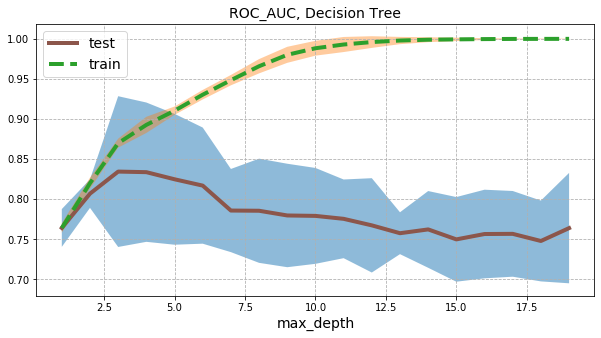

In [37]:
dtc = DecisionTreeClassifier()

# проведем GridSearch по глубине
parameters = {
    'max_depth': range(1, 20),
}
grid_cv_dtc = GridSearchCV(dtc, parameters, scoring='roc_auc', cv=5, return_train_score=True)
grid_cv_dtc.fit(X_train[col_num], y_train)

# график
plot_grid_search(grid_cv_dtc, key='max_depth', title='ROC_AUC, Decision Tree', xlabel='max_depth')

Попробуем взять много деревьев и усредним результат

In [38]:
kf = KFold(n_splits=5, random_state=123, shuffle=True)
test_res_roc_auc = []
test_res_acc = []

for train_index, val_index in kf.split(X_train[col_num]):
    
    y_pred = np.zeros(val_index.size)
    y_pred_proba = np.zeros(val_index.size)
    l = 0
    
    for max_depth_ in range(2, 10):
        dtc = DecisionTreeClassifier(max_depth=max_depth_)
        dtc.fit(X_train[col_num].iloc[train_index], y_train.iloc[train_index])
        y_pred_proba += dtc.predict_proba(X_train[col_num].iloc[val_index])[:, 1]
        y_pred += dtc.predict_proba(X_train[col_num].iloc[val_index])[:, 1]
        l += 1
        
    y_pred_proba /= l
    y_pred /= l
    y_pred = np.round(y_pred)
    
    test_res_roc_auc.append(metrics.roc_auc_score(y_train.iloc[val_index], y_pred_proba))
    test_res_acc.append(metrics.accuracy_score(y_train.iloc[val_index], y_pred))


print("test\troc_auc:\t{0} +- {1}".format(np.round(np.mean(test_res_roc_auc), 3), 
                                          np.round(2 * np.std(test_res_roc_auc), 4)))
print("test\taccuracy:\t{0} +- {1}".format(np.round(np.mean(test_res_acc), 3), 
                                           np.round(2 * np.std(test_res_acc), 4)))

test	roc_auc:	0.864 +- 0.0692
test	accuracy:	0.824 +- 0.0398


In [39]:
y_pred_final = np.zeros(test[col_num].shape[0])
l = 0

for max_depth_ in range(2, 10):
    dtc = DecisionTreeClassifier(max_depth=max_depth_)
    dtc.fit(X_train[col_num], y_train)
    y_pred_final += dtc.predict_proba(test[col_num])[:, 1]
    l += 1
    
y_pred_final /= l
y_pred_final = np.round(y_pred_final)

# формирование сабмита
to_kaggle(y_pred_final, 'decision tree bagging (max_depth = 2..9)')

# RandomForest

**GridSearch: n_estimators + график среднего качества и доверительного интервала**

best_param = {'n_estimators': 18}
best_score = 0.8531392745185847


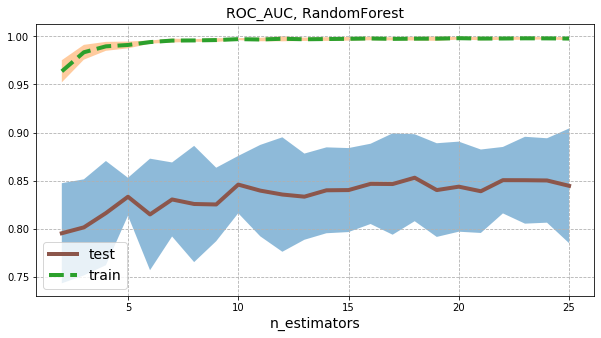

In [40]:
rfc = RandomForestClassifier()
parameters = {
    'n_estimators': range(2, 26), 
}
grid_cv_rfc = GridSearchCV(rfc, parameters, scoring='roc_auc', cv=5, return_train_score=True)
grid_cv_rfc.fit(X_train[col_num], y_train)

# результаты
print("best_param =", grid_cv_rfc.best_params_)
print("best_score =", grid_cv_rfc.best_score_)

# график
plot_grid_search(grid_cv_rfc, key='n_estimators', title='ROC_AUC, RandomForest', xlabel='n_estimators')

Возьмем **n_estimators=23** (хотя ничем не отличается существенно)

In [46]:
rfc = RandomForestClassifier(n_estimators=23)
rfc.fit(X_train[col_num], y_train)
y_pred = rfc.predict(X_val[col_num])
y_pred_proba = rfc.predict_proba(X_val[col_num])[:, 1]
print("test\troc_auc:\t{0}".format(metrics.roc_auc_score(y_val, y_pred_proba)))
print("test\taccuracy:\t{0}".format(metrics.accuracy_score(y_val, y_pred)))

test	roc_auc:	0.8920377867746287
test	accuracy:	0.8379888268156425


**Формирование файла для сабмита**

In [47]:
y_pred_final = rfc.predict(test[col_num])
to_kaggle(y_pred_final, file_name='pred_rand_forest (n_estimators=150)')

In [142]:
kf = KFold(n_splits=5, random_state=123, shuffle=True)
test_res_roc_auc = []
test_res_acc = []

for train_index, val_index in kf.split(X_train[col_num]):
    
    y_pred = np.zeros(val_index.size)
    y_pred_proba = np.zeros(val_index.size)
    l = 0
    
    for n_estimators_ in range(15, 150):
        rfc = RandomForestClassifier(n_estimators=n_estimators_)
        rfc.fit(X_train[col_num].iloc[train_index], y_train.iloc[train_index])
        y_pred_proba += rfc.predict_proba(X_train[col_num].iloc[val_index])[:, 1]
        y_pred += rfc.predict_proba(X_train[col_num].iloc[val_index])[:, 1]
        l += 1
        
    y_pred_proba /= l
    y_pred /= l
    y_pred = np.round(y_pred)
    
    test_res_roc_auc.append(metrics.roc_auc_score(y_train.iloc[val_index], y_pred_proba))
    test_res_acc.append(metrics.accuracy_score(y_train.iloc[val_index], y_pred))


print("test\troc_auc:\t{0} +- {1}".format(np.round(np.mean(test_res_roc_auc), 3), 
                                          np.round(2 * np.std(test_res_roc_auc), 4)))
print("test\taccuracy:\t{0} +- {1}".format(np.round(np.mean(test_res_acc), 3), 
                                           np.round(2 * np.std(test_res_acc), 4)))

test	roc_auc:	0.848 +- 0.042
test	accuracy:	0.796 +- 0.0596


In [143]:
y_pred_final = np.zeros(test[col_num].shape[0])
l = 0

for n_estimators_ in range(15, 150):
    rfc = RandomForestClassifier(n_estimators=n_estimators_)
    rfc.fit(X_train[col_num], y_train)
    y_pred_final += dtc.predict_proba(test[col_num])[:, 1]
    l += 1
    
y_pred_final /= l
y_pred_final = np.round(y_pred_final)

# формирование сабмита
to_kaggle(y_pred_final, 'RF bagging (max_depth = 15..150)')

# KNN

**GridSearch: число соседей**

In [48]:
neigh = KNeighborsClassifier()
parameters = {'n_neighbors': range(2, 150)}
grid_cv_knn = GridSearchCV(neigh, parameters, scoring='roc_auc', cv=5, return_train_score=True)
grid_cv_knn.fit(X_train_norm, y_train)

print("best_param =", grid_cv_knn.best_params_)
print("best_score =", grid_cv_knn.best_score_)

best_param = {'n_neighbors': 10}
best_score = 0.8393913270637409


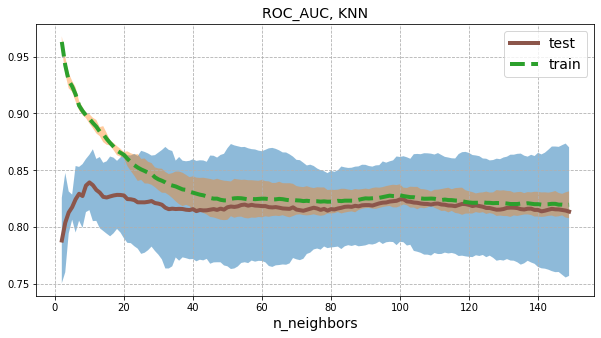

In [49]:
plot_grid_search(grid_cv_knn, key='n_neighbors', title='ROC_AUC, KNN', xlabel='n_neighbors')

In [55]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train_norm, y_train)
y_pred = neigh.predict(X_val_norm)
y_pred_proba = neigh.predict_proba(X_val_norm)[:, 1]
print("test\troc_auc:\t{0}".format(metrics.roc_auc_score(y_val, y_pred_proba)))
print("test\taccuracy:\t{0}".format(metrics.accuracy_score(y_val, y_pred)))

test	roc_auc:	0.9001349527665319
test	accuracy:	0.8379888268156425


**Формирование сабмита**

In [56]:
y_pred_final = neigh.predict(test_norm)
to_kaggle(y_pred_final, file_name='pred_knn_10')

# KNN: бэггинг

In [57]:
y_pred = np.zeros(test.shape[0])
l = 0

for n_neighbors_ in range(15, 125):
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors_)
    neigh.fit(X_train_norm, y_train)
    y_pred += neigh.predict(test_norm)
    l += 1

y_pred /= l
y_pred = np.round(y_pred)

to_kaggle(y_pred_final, file_name='knn (15..125)')

# Linear model

In [61]:
sgd = linear_model.SGDClassifier()
parameters = {'loss': ["hinge", "log", "modified_huber", "squared_hinge",\
                       "perceptron", "squared_loss", "huber", "epsilon_insensitive",\
                       "squared_epsilon_insensitive"]}
grid_cv_sgd = GridSearchCV(sgd, parameters, scoring='roc_auc', cv=5, return_train_score=True)
grid_cv_sgd.fit(X_train_norm, y_train)
print("best_param =", grid_cv_sgd.best_params_)
print("best_score =", grid_cv_sgd.best_score_)

best_param = {'loss': 'huber'}
best_score = 0.7904523063143752


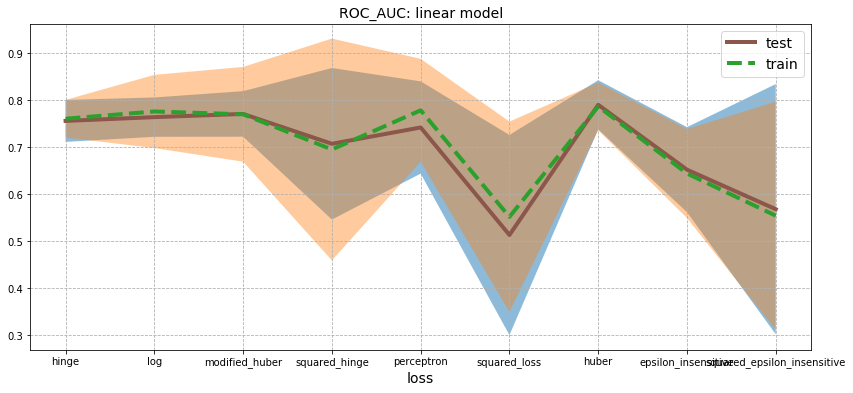

In [63]:
plot_grid_search(grid_cv_sgd, key='loss', title='ROC_AUC: linear model', xlabel='loss', figsize=(14,6))

In [64]:
sgd = linear_model.SGDClassifier(loss='huber')
sgd.fit(X_train_norm, y_train)
y_pred = neigh.predict(X_val_norm)
y_pred_proba = neigh.predict_proba(X_val_norm)[:, 1]
print("test\troc_auc:\t{0}".format(metrics.roc_auc_score(y_val, y_pred_proba)))
print("test\taccuracy:\t{0}".format(metrics.accuracy_score(y_val, y_pred)))

test	roc_auc:	0.8498650472334682
test	accuracy:	0.7932960893854749


**Формирование сабмита**

In [66]:
y_pred_final = sgd.predict(test_norm)
to_kaggle(y_pred_final, file_name='pred_sgd_huber')

In [40]:
from catboost import CatBoostClassifier, cv, Pool

In [38]:
model = CatBoostClassifier(custom_metric=['F1', 'Accuracy'],
                           cat_features=col_object)

grid = {'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
        'depth': [2, 3, 4, ],
        'l2_leaf_reg': [0, 1, 2, ]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train[col_all], 
                                       y=y_train,
                                       cv=5,
                                       verbose=False,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4039779031
bestIteration = 955


bestTest = 0.3961833564
bestIteration = 959


bestTest = 0.3964923284
bestIteration = 588


bestTest = 0.3951124936
bestIteration = 175


bestTest = 0.3857317659
bestIteration = 218


bestTest = 0.4209510623
bestIteration = 996


bestTest = 0.4068897718
bestIteration = 999


bestTest = 0.400715063
bestIteration = 597


bestTest = 0.401278421
bestIteration = 405


bestTest = 0.4043811856
bestIteration = 345


bestTest = 0.4218614345
bestIteration = 980


bestTest = 0.4053670801
bestIteration = 981


bestTest = 0.4026869255
bestIteration = 628


bestTest = 0.4078778725
bestIteration = 560


bestTest = 0.4105457808
bestIteration = 292


bestTest = 0.3862039706
bestIteration = 956


bestTest = 0.3768314526
bestIteration = 424


bestTest = 0.3841548494
bestIteration = 251


bestTest = 0.3723689641
bestIteration = 120


bestTest = 0.4004710083
bestIteration = 138


bestTest = 0.4122441983
bestIteration = 999


bestTest = 0.4020917308
bestIterati

KeyboardInterrupt: 

In [42]:
cv_dataset = Pool(data=X_train[col_all],
                  label=y_train,
                  cat_features=col_object)

params = {"iterations": 1000,
          "depth": 2,
          "learning_rate": 0.03,
          "l2_leaf_reg": 2.0,
          "loss_function": "Logloss",
          "custom_metric": "Accuracy",
          "verbose": False}

scores = cv(cv_dataset,
            params,
            fold_count=10, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [47]:
cbc = CatBoostClassifier(iterations=400,
                         depth=2,
                         learning_rate=0.04,
                         l2_leaf_reg=1.5,
                         verbose=False,
                         cat_features=col_object)
cbc.fit(X_train[col_all], y_train)
y_pred = cbc.predict(X_val[col_all])
y_pred_proba = cbc.predict_proba(X_val[col_all])[:, 1]

print("test\troc_auc:\t{0}".format(metrics.roc_auc_score(y_val, y_pred_proba)))
print("test\taccuracy:\t{0}".format(metrics.accuracy_score(y_val, y_pred)))

test	roc_auc:	0.9226045883940621
test	accuracy:	0.8715083798882681


In [48]:
y_pred = cbc.predict(test[col_all])
to_kaggle(y_pred, 'cbc')

In [34]:
def compute_meta_feature(regr, X_train, X_test, y_train, cv, *args, **kwargs):
    """
    Вычисление метафакторов для обучаюшего и тестового множеств
    """
    # мета-фактор для обучающего мн-ва: на чем будем дальше обучать
    valid = cross_val_predict(regr, X_train, y_train, cv=cv)
    # мета-фактор для тестового мн-ва: на чем будем предсказывать
    regr.fit(X_train, y_train)
    X_meta = regr.predict(X_test)
    
    return (valid, X_meta)

In [49]:
sgd1 = linear_model.SGDClassifier(loss='hinge')
sgd2 = linear_model.SGDClassifier(loss='log')
sgd3 = linear_model.SGDClassifier(loss='modified_huber')
sgd4 = linear_model.SGDClassifier(loss='squared_hinge')
sgd5 = linear_model.SGDClassifier(loss='perceptron')
sgd6 = linear_model.SGDClassifier(loss='squared_loss')
sgd7 = linear_model.SGDClassifier(loss='huber')
sgd8 = linear_model.SGDClassifier(loss='epsilon_insensitive')
sgd9 = linear_model.SGDClassifier(loss='squared_epsilon_insensitive')

neigh1 = KNeighborsClassifier(n_neighbors=3)
neigh2 = KNeighborsClassifier(n_neighbors=4)
neigh3 = KNeighborsClassifier(n_neighbors=5)
neigh4 = KNeighborsClassifier(n_neighbors=6)
neigh5 = KNeighborsClassifier(n_neighbors=7)
neigh6 = KNeighborsClassifier(n_neighbors=8)
neigh7 = KNeighborsClassifier(n_neighbors=9)
neigh8 = KNeighborsClassifier(n_neighbors=10)
neigh9 = KNeighborsClassifier(n_neighbors=11)
neigh10 = KNeighborsClassifier(n_neighbors=12)
neigh11 = KNeighborsClassifier(n_neighbors=13)
neigh12 = KNeighborsClassifier(n_neighbors=14)
neigh13 = KNeighborsClassifier(n_neighbors=15)
neigh14 = KNeighborsClassifier(n_neighbors=16)
neigh15 = KNeighborsClassifier(n_neighbors=17)
neigh16 = KNeighborsClassifier(n_neighbors=18)
neigh17 = KNeighborsClassifier(n_neighbors=19)
neigh18 = KNeighborsClassifier(n_neighbors=20)

dtc1 = DecisionTreeClassifier(max_depth=2)
dtc2 = DecisionTreeClassifier(max_depth=3)
dtc3 = DecisionTreeClassifier(max_depth=4)
dtc4 = DecisionTreeClassifier(max_depth=5)
dtc5 = DecisionTreeClassifier(max_depth=6)

# в кач-ве метаклассификатора будем использовать Ridge
ens_model = DecisionTreeClassifier()

# объединим все модели
models = [#rf1, rf2, rf3, rf4,
sgd1, sgd2, sgd3, sgd4, sgd5, sgd6, sgd7, sgd8, sgd9,
neigh1, neigh2, neigh3, neigh4, neigh5, neigh6, neigh7, neigh8, 
    neigh9, neigh10, neigh11, neigh12, neigh13, neigh14, neigh15, neigh16, 
    neigh17, neigh18, 
    dtc1, dtc2, dtc3, dtc4, dtc5,
]

In [37]:
from sklearn.model_selection import cross_val_predict

In [51]:
# мн-во мета-факторов для обучения
valid = np.zeros((X_norm.shape[0], len(models)))
# мн-во мета-факторов для теста
X_meta = np.zeros((X_norm_test.shape[0], len(models)))

i = 0
for model in models:
    (valid[:, i], X_meta[:, i]) = compute_meta_feature(model, X_norm, X_norm_test, y_train, cv=3)
    i += 1
    # метарегрессор
ens_model.fit(valid, y_train)
    
y_pred = ens_model.predict(X_meta)
print("test\troc_auc:\t{0}".format(metrics.roc_auc_score(np.array(y_test), y_pred)))
print("test\taccuracy:\t{0}".format(metrics.accuracy_score(np.array(y_test), y_pred)))

test	roc_auc:	0.8209851551956816
test	accuracy:	0.8435754189944135


In [52]:
# мн-во мета-факторов для обучения
valid = np.zeros((X_norm.shape[0], len(models)))
# мн-во мета-факторов для теста
X_meta = np.zeros((X_norm_.shape[0], len(models)))

i = 0
for model in models:
    (valid[:, i], X_meta[:, i]) = compute_meta_feature(model, X_norm, X_norm_, y_train, cv=3)
    i += 1

In [53]:
y_pred = ens_model.predict(X_meta)
final = pd.DataFrame()
final['PassengerId'] = test['PassengerId']
final['Survived'] = y_pred
final.head(10)
final.to_csv("C:\\Users\\dgalk\\kaggle\\Titanic\\pred_stack.csv", 
             index=False)